In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it


from scipy.integrate import trapezoid
from tqdm.notebook import tqdm
from modelbase2 import Simulator, plot
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from modelbase2 import mca
from matplotlib.colors import TwoSlopeNorm
from scipy.signal import find_peaks, peak_prominences

#plt.style.use("./notebook.mplstyle")


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


# def test_version():
#     import pkg_resources
#     from distutils.version import LooseVersion

#     version = pkg_resources.get_distribution('modelbase').version
#     if not LooseVersion(version) >= LooseVersion("1.3.8"):
#         raise ImportError(f"You need modelbase >= 1.3.8 to run this script, got {version}")


def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax


def get_avg(s: Simulator, t_end: float) -> Tuple[pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    vavg = pd.Series(
        trapezoid(v.loc[t_end * 0.75 :, :], x=v.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=v.columns,
    )

    cavg = pd.Series(
        trapezoid(c.loc[t_end * 0.75 :, :], x=c.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=c.columns,
    )

    return cavg.T, vavg.T


# test_version()

In [1]:
%%capture
cd ..

In [6]:
from model import Saadat2021

vPS2 -> v_PSII y
vPS1 -> v_PSI y
vPTOX -> v_PQ y
vNDH _> v_NDH y
vB6f -> v_b6f y
vCyc -> v_Cyc y
vFNR -> v_FNR y
vLeak -> v_Leak y
vSt12 v_St21 y
vSt21 v_St12 y
vATPsynthase v_ATPsynth y
vDeepox v_Deepox y
vEpox v_Epox y
vLhcprotonation v_PsbSP y
vLhcdeprotonation v_PsbSD y
vRuBisCO v_RuBisCO y
vPGA_kinase v_PGK1ase y
vBPGA_dehydrogenase v_BPGAdehynase y
vTPI v_TPIase y
vAldolase v_Aldolase_FBP y
vFBPase v_FBPase y
vF6P_Transketolase
v8 v_Aldolase_SBP y
v9 v_SBPase y
v10 v_TKase_R5P y
v11 v_Rpiase y
v12 v_RPEase y
v13 v_PRKase y
vG6P_isomerase v_PGIase y
vPhosphoglucomutase v_PGMase y
vpga v_pga_ex y
vgap v_gap_ex y
vdhap v_dhap_ex y
vStarch v_starch y
vFdred v_Fdred y
vAscorbate v_APXase y
vMDAreduct v_MDAreduct y
vMehler v_Mehler y
vGR v_GR y
vDHAR v_DHAR y
v3ASC v_3ASC y
vEX_ATP v_ATPcons y
vEX_NADPH v_NADPHcons y
vFdTrReductase v_FdTrReduc y
vE_activation v_Eact y
vE_inactivation v_Einact y

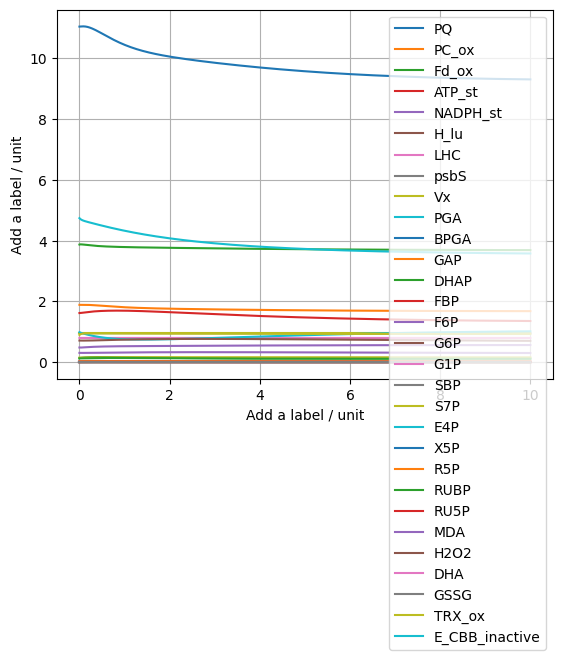

In [7]:
s = Simulator(Saadat2021())

concs, fluxes = (
    Simulator(Saadat2021())  # initialise the simulator
    .simulate(10)  # simulate until t_end = 5 a.u.
    .get_concs_and_fluxes()  # return pd.DataFrames for concentrations and fluxes
)

fig, ax = plot.lines(concs)
# plt.legend(loc = 'best')
plt.show()
# if concs is not None and fluxes is not None:
#     fig, (ax1, ax2) = plot.two_axes(figsize=(6, 2.5))
#     _ = plot.lines(concs, ax=ax1)
#     # _ = plot.lines(fluxes, ax=ax2)

#     # Never forget to labelr you axes :)
#     ax1.set(xlabel="time / a.u.", ylabel="concentration / a.u.")
#     # ax2.set(xlabel="time / a.u.", ylabel="flux / a.u.")
#     plt.show()

In [33]:
from modelbase2 import make_protocol

def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

In [14]:
s1 = Simulator(Saadat2021())
# s1.initialise(y0)
s1.update_parameter("k_cyc", 0.0)
s1.clear_results()


In [ ]:
t_relax=120
t_pulse=0.8
numpeaks_phase0=2
numpeaks_phase1=10
pfd_dark=50
pfd_illumination=1000
pfd_pulse=5000

s1, pam_ptrc = pam2(
    s1,
    t_relax=t_relax,
    t_pulse=t_pulse,
    numpeaks_phase0=numpeaks_phase0,
    numpeaks_phase1=numpeaks_phase1,
    pfd_dark=pfd_dark,
    pfd_illumination=pfd_illumination,
    pfd_pulse=pfd_pulse,
)


In [34]:

time, Fm, NPQ, Fo = npq2(
    s=s1,
    peak_distance=(t_relax+t_pulse)
)

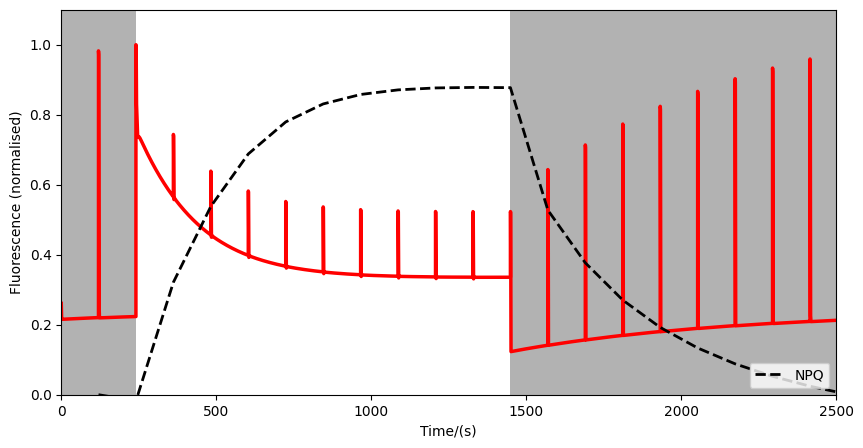

In [41]:
from modelbase2 import plot
    
c = s1.get_full_concs()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", lw=2.5)
ax.plot(time, NPQ, linestyle="dashed", color="black", label="NPQ", lw=2)

pam_ptrc_cleaned = pam_ptrc[pam_ptrc['pfd'] != pfd_pulse]

plot.shade_protocol(
    pam_ptrc_cleaned['pfd'],
    ax=ax,
    vmin=pfd_dark,
    vmax=pfd_illumination,
    add_legend=False,
    alpha=0.3
)

ax.set(
    ylim=(0, 1.1),
    xlim=(0, 2500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)
ax.legend(loc="lower right")
plt.show()